In [1]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from autoencoder import full_network
from training import create_feed_dictionary
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
data_path_original = '../../sindy_models/original/'
data_path_verification = '../../sindy_models/verification/'

save_names = {
    data_path_original + 'model1': 'O1',
    data_path_original + 'model2': 'O2', 
}

for i in range(1, 11):
    save_names[data_path_verification + f'V{i}'] = f'V{i}'

# Test all 10 replicated models

In [4]:
with open('../../test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [5]:
results = {k: {} for k in save_names}

In [6]:
for save_name in save_names:
    tf.reset_default_graph()
    params = pickle.load(open(save_name + '_params.pkl', 'rb'))
    params['save_name'] = save_name

    autoencoder_network = full_network(params)
    learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

    tensorflow_run_tuple = ()
    for key in autoencoder_network.keys():
        tensorflow_run_tuple += (autoencoder_network[key],)

    # Test
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,  save_name)
        test_dictionary = create_feed_dictionary(test_data, params)
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

    test_set_results = {}
    for i,key in enumerate(autoencoder_network.keys()):
        test_set_results[key] = tf_results[i]

    results[save_name]['z'] = test_set_results['z']
    results[save_name]['dz'] = test_set_results['dz']
    results[save_name]['coefficients'] = test_set_results['sindy_coefficients']
    results[save_name]['coefficient_mask'] = test_set_results['coefficient_mask']

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1
INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V1
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V3
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V4
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V5
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V6
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V7
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V8
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V9
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V10


In [7]:
coefficient_names = np.array(['1', f'z_{0 + 1}', f'z_{1 + 1}', f'z_{2 + 1}', f'z_{0 + 1}^2', f'z_{0 + 1}z_{1 + 1}', f'z_{0 + 1}z_{2 + 1}', f'z_{1 + 1}^2', f'z_{1 + 1}z_{2 + 1}',
    f'z_{2 + 1}^2', f'z_{0 + 1}^3', f'z_{0 + 1}^2z_{1 + 1}', f'z_{0 + 1}^2z_{2 + 1}', f'z_{0 + 1}z_{1 + 1}^2', f'z_{0 + 1}z_{1 + 1}z_{2 + 1}', f'z_{0 + 1}z_{2 + 1}^2',
    f'z_{1 + 1}^3', f'z_{1 + 1}^2z_{2 + 1}', f'z_{1 + 1}z_{2 + 1}^2', f'z_{2 + 1}^3'], dtype=object)
  

In [8]:
permuations = [(0, 1, 2), (2, 0, 1), (0, 1, 2), (1, 2, 0), (0, 2, 1), (1, 0, 2),
(0, 1, 2), (0, 1, 2), (1, 0, 2), (1, 0, 2), (1, 2, 0), (1, 0, 2)]

coefficient_names_perm = [
    np.array(['1', f'z_{perm[0] + 1}', f'z_{perm[1] + 1}', f'z_{perm[2] + 1}', f'z_{perm[0] + 1}^2', f'z_{perm[0] + 1}z_{perm[1] + 1}', f'z_{perm[0] + 1}z_{perm[2] + 1}', f'z_{perm[1] + 1}^2', f'z_{perm[1] + 1}z_{perm[2] + 1}',
    f'z_{perm[2] + 1}^2', f'z_{perm[0] + 1}^3', f'z_{perm[0] + 1}^2z_{perm[1] + 1}', f'z_{perm[0] + 1}^2z_{perm[2] + 1}', f'z_{perm[0] + 1}z_{perm[1] + 1}^2', f'z_{perm[0] + 1}z_{perm[1] + 1}z_{perm[2] + 1}', f'z_{perm[0] + 1}z_{perm[2] + 1}^2',
    f'z_{perm[1] + 1}^3', f'z_{perm[1] + 1}^2z_{perm[2] + 1}', f'z_{perm[1] + 1}z_{perm[2] + 1}^2', f'z_{perm[2] + 1}^3'], dtype=object)
    for perm in permuations]

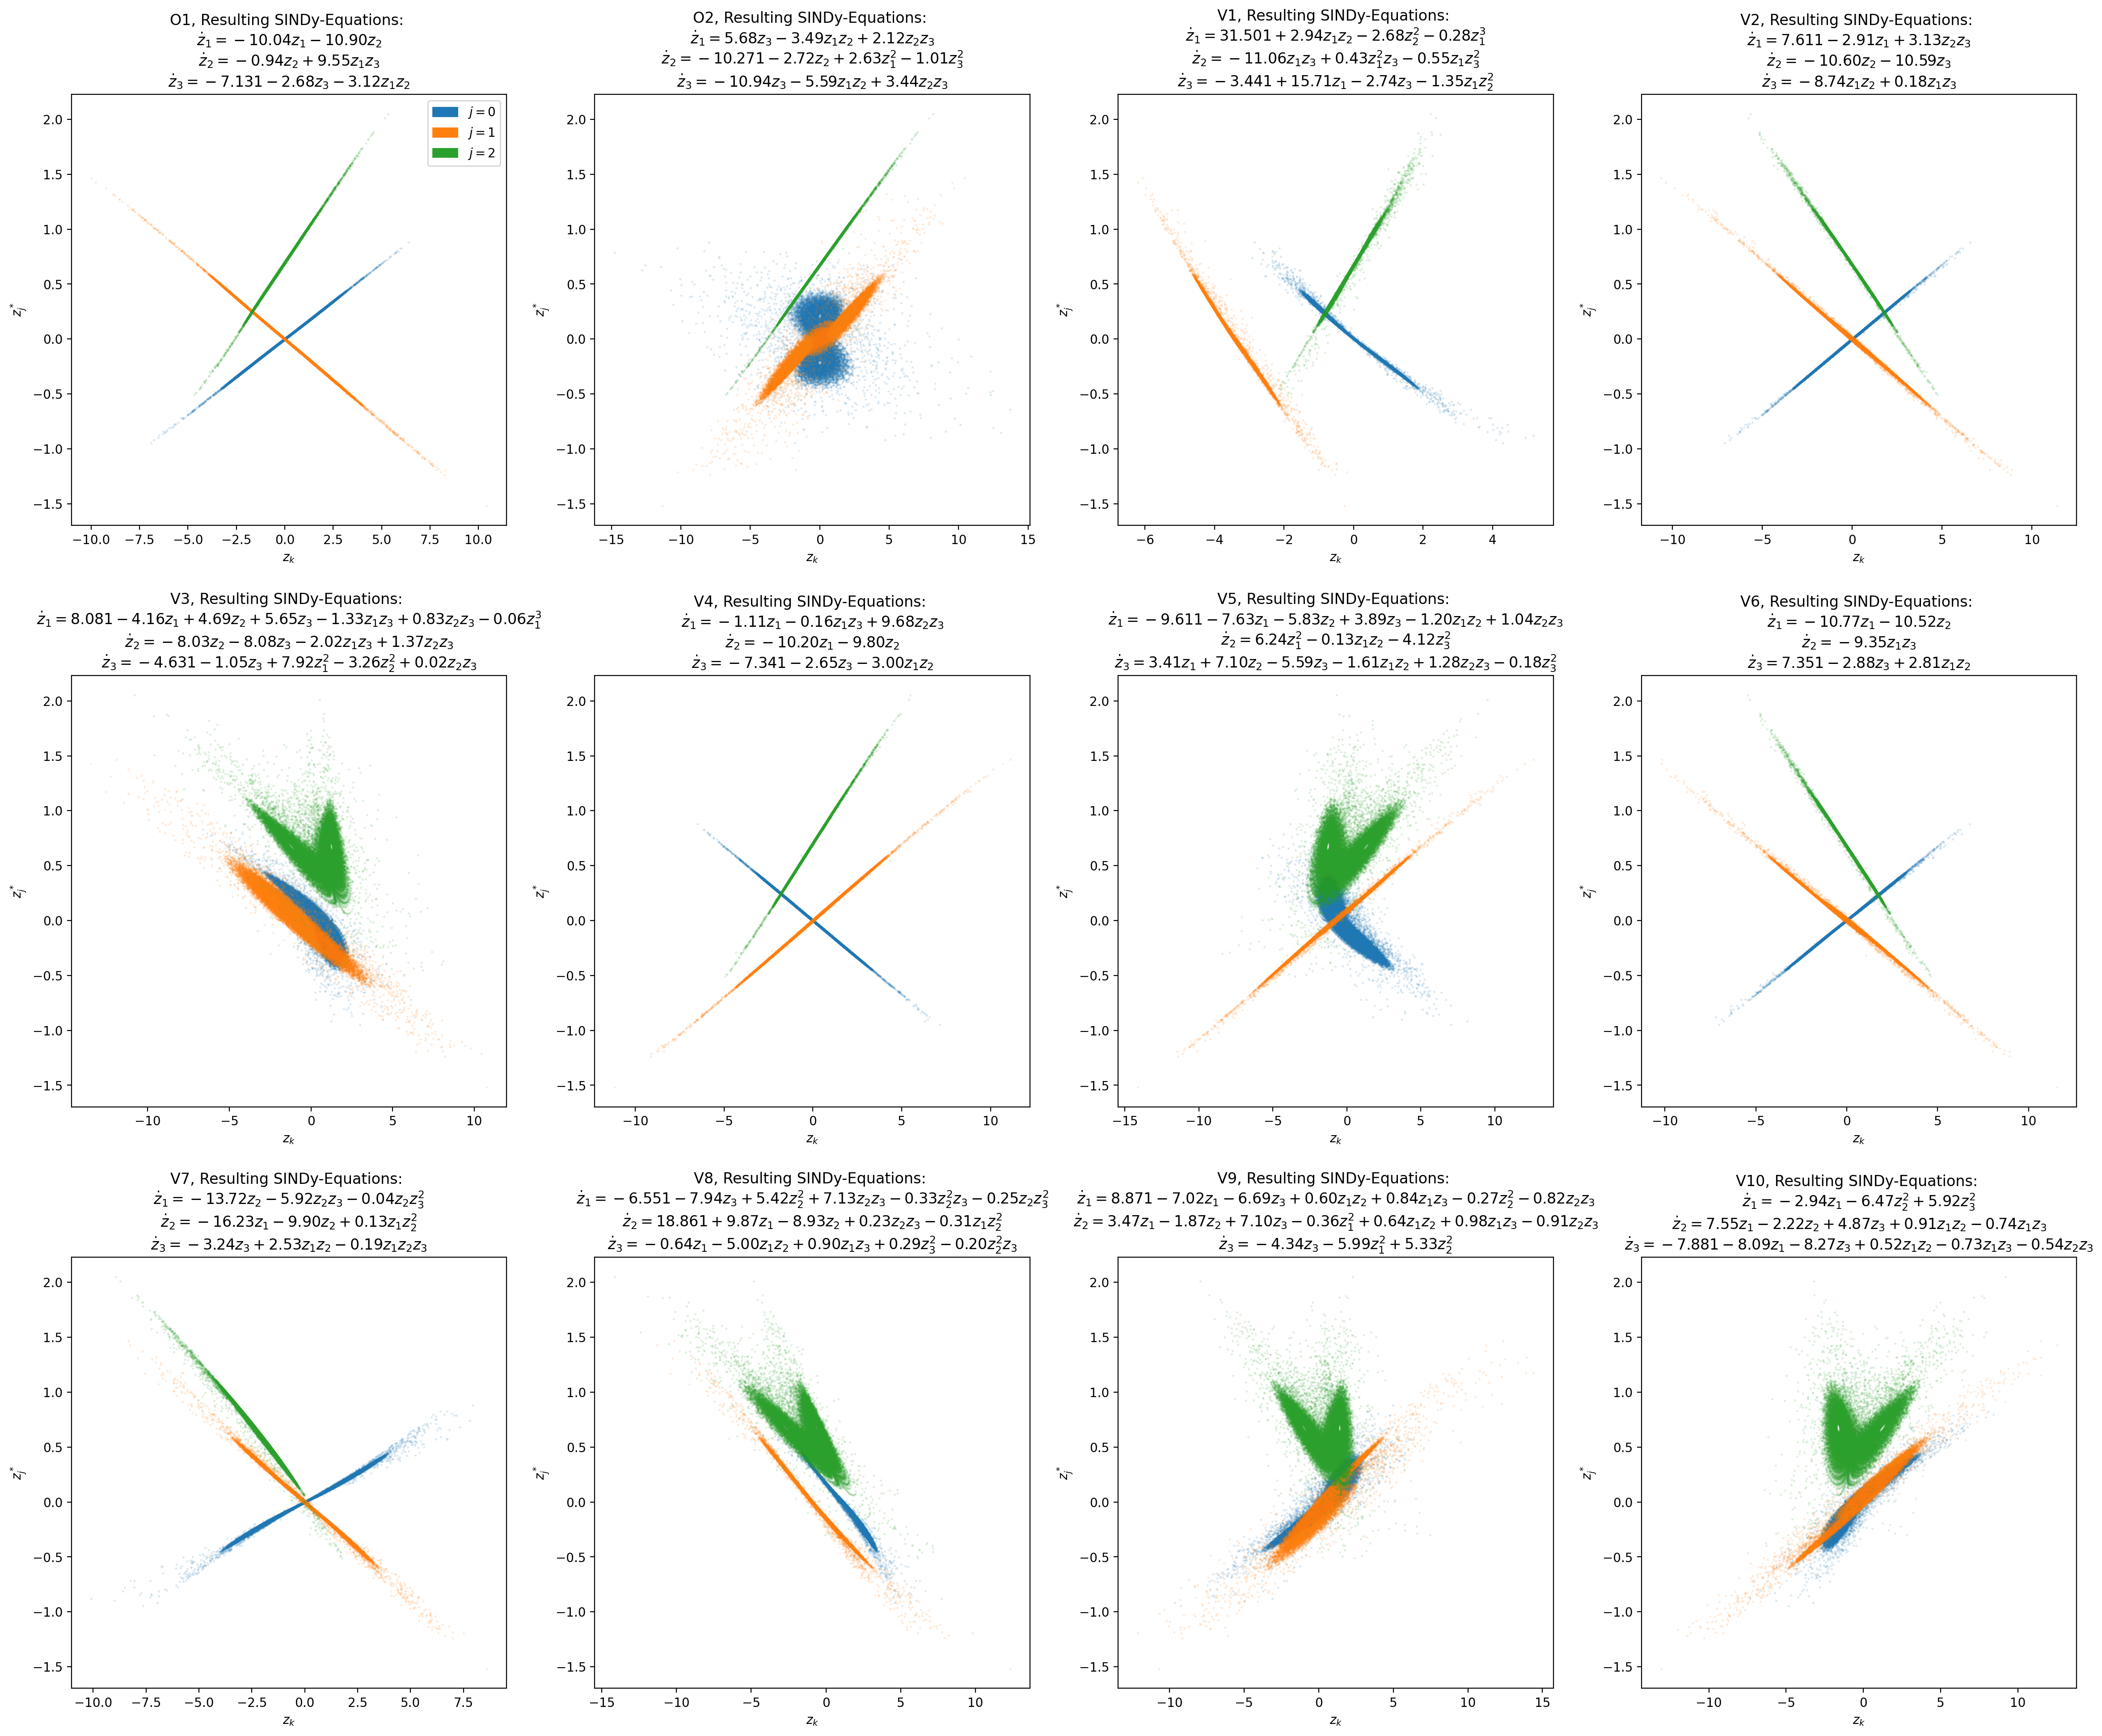

In [9]:
ROWS = 4

fig, axes = plt.subplots(3, ROWS, figsize=(44/1.9, 35/1.9), dpi=200)
fig.tight_layout(w_pad=4, h_pad=10)

z_linspace = np.linspace(-np.pi, np.pi, 100)

for i, (save_name, perm) in enumerate(zip(save_names, permuations)):
    axes[i//ROWS][i%ROWS].scatter(results[save_name]['z'][:, perm[0]].flatten(), test_data['z'].reshape(-1, 3)[:, 0].flatten(), label=r'$j = 0$' if i == 0 else None, s=1, alpha=0.1)
    axes[i//ROWS][i%ROWS].scatter(results[save_name]['z'][:, perm[1]].flatten(), test_data['z'].reshape(-1, 3)[:, 1].flatten(), label=r'$j = 1$' if i == 0 else None, s=1, alpha=0.1)
    axes[i//ROWS][i%ROWS].scatter(results[save_name]['z'][:, perm[2]].flatten(), test_data['z'].reshape(-1, 3)[:, 2].flatten(), label=r'$j = 2$' if i == 0 else None, s=1, alpha=0.1)

    eq = ['' for _ in range(results[save_name]['coefficients'].shape[1])]

    for k in range(len(eq)):
        eq[k] = r'$\dot z_' + f'{k+1}' + ' = '
        for j, (coef, coef_name) in enumerate(zip(results[save_name]['coefficients'][:, k], coefficient_names)):
            if not results[save_name]["coefficient_mask"][:, k].astype(bool).flatten()[j]: continue
            eq[k] += ('+' if coef >= 0 and eq[k] != r'$\dot z_' + f'{k+1}' + ' = ' else '') + f'{coef:.2f}' + coef_name
        if not results[save_name]["coefficient_mask"][:, k].astype(bool).any(): eq[k] += '0'
        eq[k] += r'$'

    axes[i//ROWS][i%ROWS].set_title((f'V{i-1}' if i > 1 else f'O{i+1}') + ', Resulting SINDy-Equations: \n' + eq[0] + '\n' + eq[1]+ '\n' + eq[2])
    if i == 0:
        patch1 = mpatches.Patch(color='tab:blue', label=r'$j = 0$')
        patch2 = mpatches.Patch(color='tab:orange', label=r'$j = 1$')
        patch3 = mpatches.Patch(color='tab:green', label=r'$j = 2$')
        axes[i//ROWS][i%ROWS].legend(handles=[patch1, patch2, patch3])
    axes[i//ROWS][i%ROWS].set_ylabel(r'$z_j^*$'); axes[i//ROWS][i%ROWS].set_xlabel(r"$z_k$");